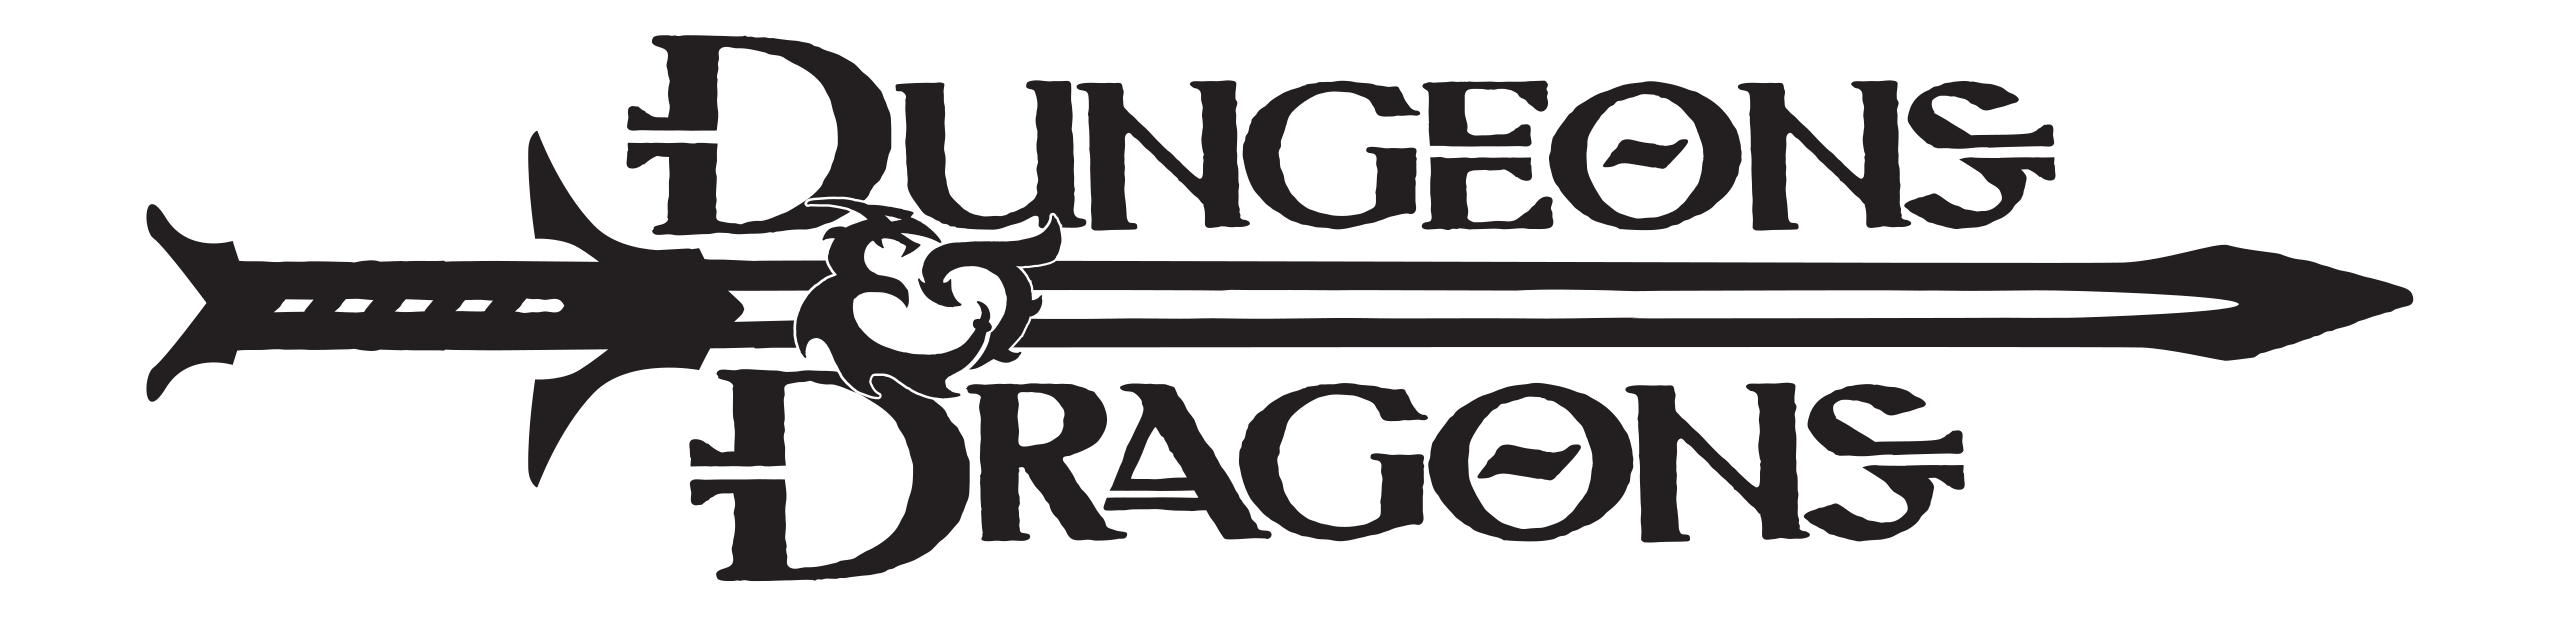

***Project By:** Kay Crapoff, Mahjan "MJ" Rastegarlar, Noah Neuman, Zach Dorff*

**Data:** https://www.kaggle.com/datasets/patrickgomes/dungeons-and-dragons-5e-monsters

In [113]:
# Including needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans


In [114]:
# Pull data from file and clean it up (Zach)
# Pull data from csv
df = pd.read_csv('Dd5e_monsters.csv')
# Create map to convert size and alignment to numeric values
sizemap = {"Tiny": 1,"Small": 3, "Medium": 6,  "Large": 9, "Huge": 12, "Gargantuan": 15}
allmap = {" Chaotic Evil": 0, " Chaotic Good": 1, " Chaotic Neutral": 2, " Lawful Evil": 3,
           " Lawful Good": 4, " Lawful Neutral": 5, " Neutral": 6, " Neutral Evil": 7,  " Neutral Good": 8, " Any Alignment": 9,
           " Any Non-good Alignment": 10, " Any Non-lawful Alignment": 11, " Any Chaotic Alignment": 12," Unaligned": 13,}


# Split Race and Alignment into two columns
df['Race + alignment'] = df['Race + alignment'].str.replace(r'[\"\']', '')
df[['Race', 'Alignment']] = df['Race + alignment'].apply(lambda x: pd.Series(x.split(',', 1)))
#Replace alignment with the map
df.replace({"Alignment": allmap}, inplace=True)
df['Alignment'] = df['Alignment'].replace(to_replace=r'\D', value='', regex=True)
# Convert the "Alignment" column to numeric type
df['Alignment'] = pd.to_numeric(df['Alignment'], errors='coerce')
df['Alignment'].fillna(0, inplace=True)
# Create a boolean mask for rows where Alignment is higher than 13
mask = df['Alignment'] > 13
# Drop rows based on the boolean mask
df.drop(df[mask].index, inplace=True)
# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)
# Drop race too many values to map



df.drop("Race", axis=1, inplace=True)
# Drop duplicate columns
df.drop("Race + alignment", axis=1, inplace=True)
# Replace size with numeric values
df.replace({"Size": sizemap}, inplace=True)
# Extract non numeric values from the "HP" "Armor" and "Challenge rating" column
df['HP'] = df['HP'].str.extract('(\d+)', expand=False)
df['HP'] = pd.to_numeric(df['HP'], errors='coerce')
df['Armor'] = df['Armor'].str.extract('(\d+)', expand=False)
df['Armor'] = pd.to_numeric(df['Armor'], errors='coerce')
df['Speed'] = df['Speed'].str.extractall('(\d+)').astype(float).groupby(level=0).sum()
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
df['Challenge rating  (XP)'] = df['Challenge rating  (XP)'].str.extract(r'"?(\d+)"?')
# Convert the extracted values to numeric type
df['Challenge rating  (XP)'] = pd.to_numeric(df['Challenge rating  (XP)'], errors='coerce')
df[["Challenge rating  (XP)"]].to_csv('Challenge rating.csv', index=False)
df.rename(columns={'Challenge rating  (XP)': 'Challenge Rating'}, inplace=True)




labels = pd.DataFrame({'labels': df['Challenge Rating'].astype(int)})
labels.to_csv('labels.csv', index=False)
names = pd.DataFrame({'labels': df['Name']})
#Remove name and CR from the dataframe as name is too diffictult to map and CR is the label
df.drop("Name", axis=1, inplace=True)
df.drop("Challenge Rating", axis=1, inplace=True)


df.to_csv('Dd5e_monsters_clean.csv', index=False)
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)
scaled_dataFrame = pd.DataFrame(scaled_data, columns=df.columns)
scaled_dataFrame.to_csv('Dd5e_monsters_clean_scaled.csv', index=False)
# Check for missing values in features and labels
print("Missing values in features:")
print(df.isnull().sum())

print("\nMissing values in labels:")
print(labels.isnull().sum())

Missing values in features:
Size         0
HP           0
Armor        0
Speed        0
Alignment    0
dtype: int64

Missing values in labels:
labels    0
dtype: int64


/var/folders/z1/cdnk_7952_1gkctwd9vzkdqm0000gn/T/ipykernel_95643/2374213858.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Race + alignment'] = df['Race + alignment'].str.replace(r'[\"\']', '')


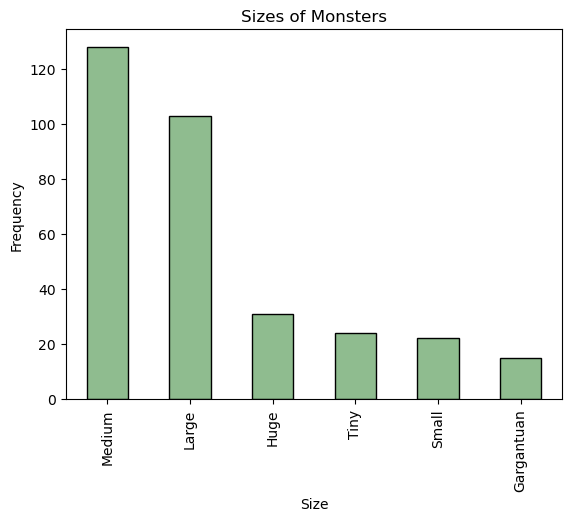

In [115]:
# Graph data to visualize it (Kay)
df['Size'].value_counts().plot.bar(color='darkseagreen', edgecolor='black')
ticks = [3, 4, 0, 1, 2, 5]
plt.xticks(ticks=ticks, labels=sizemap)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Sizes of Monsters')
plt.show()

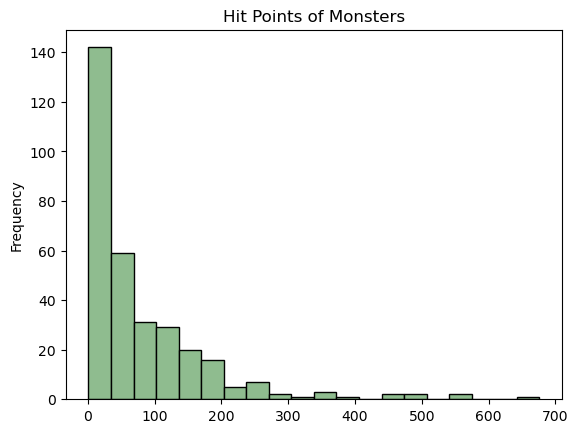

In [116]:
df['HP'].plot.hist(bins=20, color='darkseagreen', edgecolor='black')
#plt.xlabel('Hit Points (HP)')
plt.ylabel('Frequency')
plt.title('Hit Points of Monsters')
plt.show()

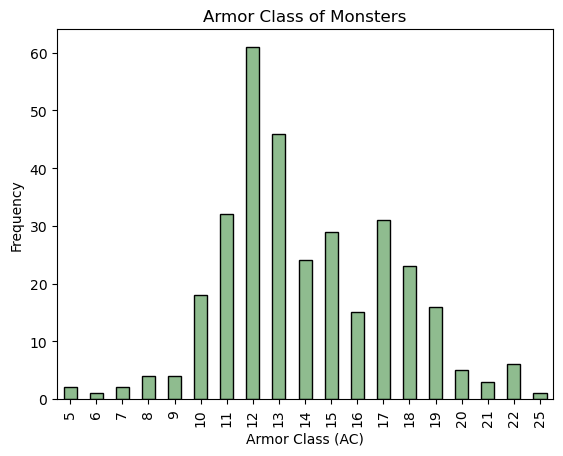

In [117]:

# Group by 'Armor' and count the occurrences
armor_counts = df.groupby('Armor').size().sort_index()

# Plotting
armor_counts.plot.bar(color='darkseagreen', edgecolor='black')
plt.xlabel('Armor Class (AC)')
plt.ylabel('Frequency')
plt.title('Armor Class of Monsters')
plt.show()
#df['Armor'].value_counts().plot.bar(color='skyblue', edgecolor='black')
#plt.xlabel('Armor Class (AC)')
#plt.ylabel('Frequency')
#plt.title('Armor Class of Monsters')
#plt.show()

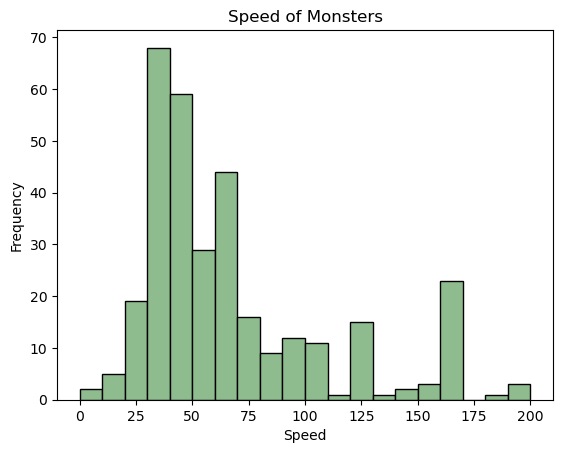

In [118]:
df['Speed'].plot.hist(bins=20, color='darkseagreen', edgecolor='black')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Speed of Monsters')
plt.show()

In [119]:
# Build Model (Noah)
# Read into features and target (X and y)
X = scaled_dataFrame
y = labels['labels']  # Target variable

# initialize kfold
#this process will split the data into 4 parts for training and testing
kf = KFold(n_splits=4, shuffle=True, random_state=42)

#initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

#kfold cross validation training
#this valuates how well our model performs across different subsets of the data
scores = cross_val_score(model, X, y, cv=kf, scoring = 'neg_mean_squared_error')

#calculate root mean squared error for each fold
#this number is a measure of how accurately the model predicts the target variable
rmse_scores = np.sqrt(-scores)

#split the data into training and testing sets
#this is done to have a separate dataset to test the model on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Model & Fit Model (Noah)

#train model x train is features y train is labels
# use features to estimate
model.fit(X_train, y_train)

# make predictions using the model on the test data
predictions = model.predict(X_test)

#calculate mean scared error and root mean squared error
#these metrics help evaluate the model's accuracy
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

#R^2 score pries a measure of how well observed outcomes are replicated by the model
r2 = r2_score(y_test, predictions)

# outputting feature importances
#this will show what feature is most influential to the models predictions
feature_importances = model.feature_importances_
features_list = X.columns
feature_importance_info = sorted(zip(feature_importances, features_list), reverse=True)

print(f'Root Mean Squared Error: {rmse} (root of MSE(average error between prediction and actual value ))')
print(f'R^2 Score: {r2} (how well the model performs)')
print("Feature Importances:")

for importance, feature in feature_importance_info:
    print(f'{feature}: {importance}')

Root Mean Squared Error: 1.392824645756658 (root of MSE(average error between prediction and actual value ))
R^2 Score: 0.9424037468097816 (how well the model performs)
Feature Importances:
HP: 0.9327895314345328
Armor: 0.027071115475679676
Size: 0.01519199024887919
Speed: 0.014331742451493625
Alignment: 0.01061562038941479


In [120]:
#PCA method (Noah)
from sklearn.decomposition import PCA

#apply PCA (principle component analysis) to reduce the number of features
pca = PCA(n_components=5)  # Adjust the number of components as necessary
X_pca = pca.fit_transform(X) #transform the data using PCA

n_clusters = 3  # Adjust the number of clusters as necessary

#kmeans is used to group data into clusters based on similarities
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_clusters = kmeans.fit_predict(X_pca)

# Initialize kfold
#divides the data into 4 parts for training and testing
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Kfold cross validation
#evaluates the models performance across different subsets of the data
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate root mean squared error for each fold
#this provides a measure of accuracy for the model
rmse_scores = np.sqrt(-scores)

# Split the data into training and testing sets
#this allows us to assess the models performance on unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train model - X_train is features, y_train is labels
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Outputting feature importances
feature_importances = model.feature_importances_
features_list = X.columns.tolist()
feature_importance_info = sorted(zip(feature_importances, features_list), reverse=True)

print([feature_importances, features_list])

print(f'Root Mean Squared Error: {rmse} (root of MSE(average error between prediction and actual value))')
print(f'R^2 Score: {r2} (how well the model performs)')
print("Feature Importances:")
for importance, feature in feature_importance_info:
    print(f'{feature}: {importance}')

/Users/NoahNeuman_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[array([0.01519199, 0.93278953, 0.02707112, 0.01433174, 0.01061562]), ['Size', 'HP', 'Armor', 'Speed', 'Alignment']]
Root Mean Squared Error: 1.392824645756658 (root of MSE(average error between prediction and actual value))
R^2 Score: 0.9424037468097816 (how well the model performs)
Feature Importances:
HP: 0.9327895314345328
Armor: 0.027071115475679676
Size: 0.01519199024887919
Speed: 0.014331742451493625
Alignment: 0.01061562038941479


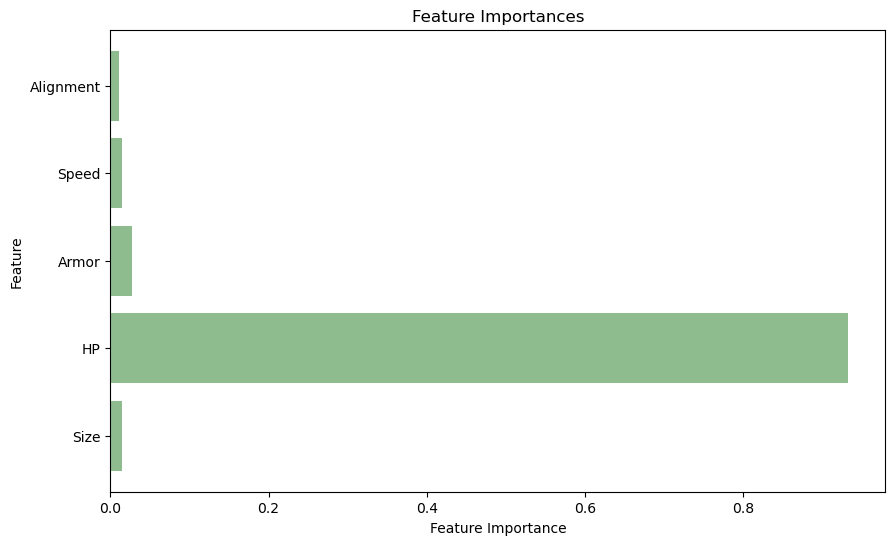

In [121]:
# Graph outcomes (Mahjan)
#Visualizing Feature Importances:
#This graph demonstrates the importance of each feature in predicting the challenge rating.
plt.figure(figsize=(10, 6))
plt.barh(range(len(features_list)), feature_importances, align='center', color='darkseagreen')
plt.yticks(range(len(features_list)), features_list)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


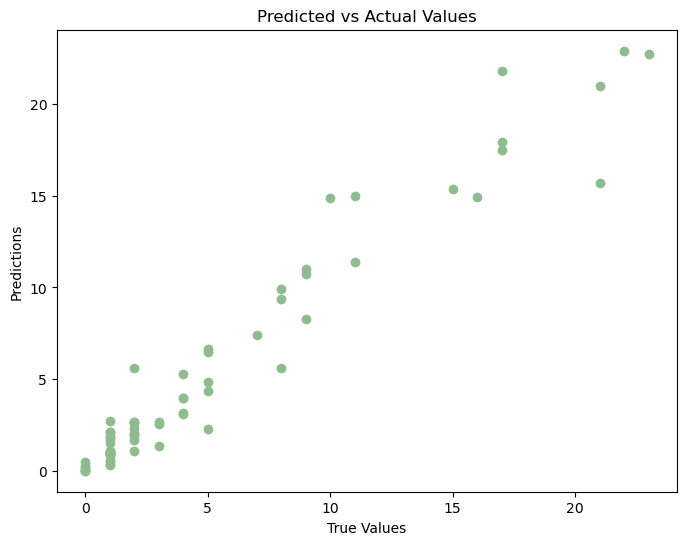

In [122]:
#Performace Comparison
#Displaying a comparison of predicted vs. actual values can illustrate the model's performance.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='darkseagreen')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs Actual Values')
plt.show()

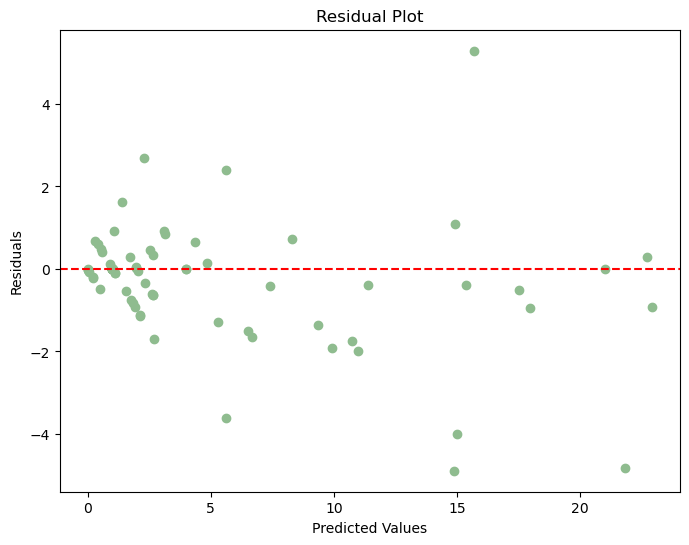

In [123]:
#Residual Plot:
#Examining the distribution of residuals can give insight into model performance.
plt.figure(figsize=(8, 6))
plt.scatter(predictions, y_test - predictions, color='darkseagreen')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

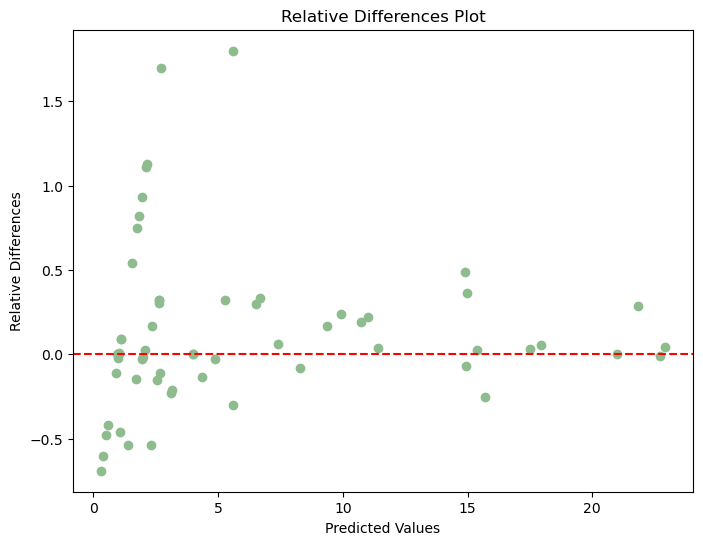

In [124]:
#Calculate relative differences between predicted and actual values MJ
relative_differences = (predictions - y_test) / y_test

plt.figure(figsize=(8, 6))
plt.scatter(predictions, relative_differences, color='darkseagreen')
plt.xlabel('Predicted Values')
plt.ylabel('Relative Differences')
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Relative Differences Plot')
plt.show()

In [125]:
#Zach Extra Stuff
from sklearn.linear_model import Ridge

kf = KFold(n_splits=10, shuffle=True, random_state=42)
X.drop("HP", axis=1, inplace=True)
all_feature_importances = []

# Calculate metrics for each fold and get feature importances
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize model
    model = Ridge(alpha=0.1)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predictions on the test set
    fold_predictions = model.predict(X_test)

    # Calculate metrics for each fold
    fold_mse = mean_squared_error(y_test, fold_predictions)
    fold_rmse = np.sqrt(fold_mse)
    fold_r2 = r2_score(y_test, fold_predictions)

    # Get feature importances for the current fold
    fold_feature_importances = model.coef_

    # Store feature importances for each fold
    all_feature_importances.append(fold_feature_importances)

    print(f'Fold {i + 1}:')
    print(f'   MSE: {fold_mse}')
    print(f'   RMSE: {fold_rmse}')
    print(f'   R^2: {fold_r2}')
    print(f'   Feature Importances: {fold_feature_importances}')
    print('---')

# Calculate overall feature importances across all folds
overall_feature_importances = np.mean(all_feature_importances, axis=0)

# Calculate overall metrics across all folds
predictions = cross_val_predict(model, X, y, cv=kf)
overall_mse = mean_squared_error(y, predictions)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(y, predictions)

print('Overall Metrics:')
print(f'   Overall MSE: {overall_mse}')
print(f'   Overall RMSE: {overall_rmse}')
print(f'   Overall R^2: {overall_r2}')
print(f'   Overall Feature Importances: {overall_feature_importances}')

Fold 1:
   MSE: 10.084442630972896
   RMSE: 3.1756011448185517
   R^2: 0.6680583355963764
   Feature Importances: [ 2.05216262  4.62486742  0.25736762 -0.88410781]
---
Fold 2:
   MSE: 10.302754993340011
   RMSE: 3.209790490567883
   R^2: 0.7326860719587518
   Feature Importances: [ 1.90489004  4.56507705  0.49075302 -0.8698831 ]
---
Fold 3:
   MSE: 6.555362845176434
   RMSE: 2.5603442825480394
   R^2: 0.794021866859105
   Feature Importances: [ 2.05820158  4.64902844  0.32439048 -0.66996084]
---
Fold 4:
   MSE: 16.980238600294108
   RMSE: 4.120708507076678
   R^2: 0.6926164667261625
   Feature Importances: [ 2.05677979  4.29501446  0.49851256 -0.57188775]
---
Fold 5:
   MSE: 5.666103792143481
   RMSE: 2.3803579126138743
   R^2: 0.6232164242382672
   Feature Importances: [ 2.09367482  4.58129428  0.40605962 -0.74704269]
---
Fold 6:
   MSE: 20.160218297442924
   RMSE: 4.490013173415299
   R^2: 0.6289641521849503
   Feature Importances: [ 2.16447701  3.5824688   0.79446682 -1.07423441]
--

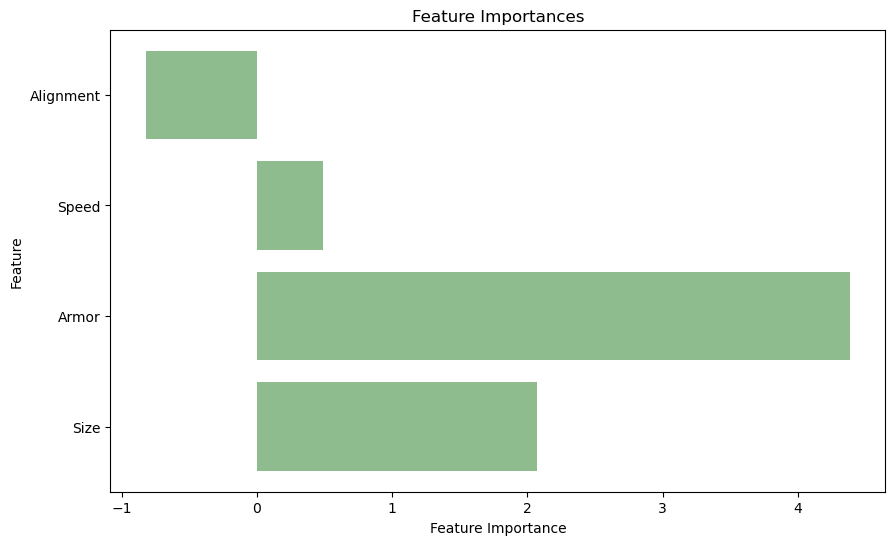

In [126]:
features_list = X.columns
#Visualizing Feature Importances:
#This graph demonstrates the importance of each feature in predicting the challenge rating.
plt.figure(figsize=(10, 6))
plt.barh(range(len(features_list)), overall_feature_importances, align='center', color='darkseagreen')
plt.yticks(range(len(features_list)), features_list)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()